# Discovery of interesting objects in large spectra survey using active deep learning

In [1]:
from active_cnn import data
from active_cnn import learning
from active_cnn import plot
from active_cnn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
from spectraml import ondrejov

Using TensorFlow backend.


In [2]:
# setup matplotlib: https://matplotlib.org/users/usetex.html
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Data

Our work is about discovery of interesting objects in LAMOST spectral survey using data from Ondřejov 2m Perek telescope.

### LAMOST spectral survey

In [4]:
# read LAMOST DR2 dataset
ids, X = data.get_lamost_dataset('data/lamost-dr2.h5')
ids.shape

(4136482,)

### Archive of Ondřejov 2m Perek telescope

In [5]:
ondrejov_data = data.get_ondrejov_dataset('data/ondrejov-dataset.csv')
ids_train, X_train, labels_train, y_train = ondrejov_data

## Preprocessing

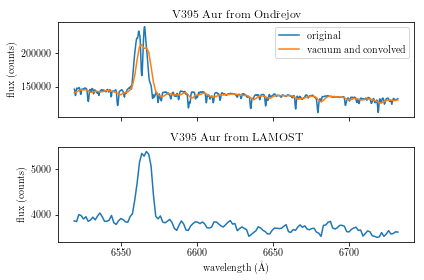

In [6]:
# define wavelengths range
wavelengths = np.linspace(start=6519, stop=6732, num=140)

def preview_domain_adaptation():
    # preview domain adaptation
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

    ondrejov_id = 'a201504150031'
    ondrejov_fits = 'data/' + ondrejov_id + '.fits'
    ondrejov_name, ondrejov_wave, ondrejov_flux = ondrejov.read_spectrum(ondrejov_fits)
    # cut only region of interest
    index = (6519 < ondrejov_wave) & (ondrejov_wave < 6732)
    # plot original spectrum
    ax1.plot(ondrejov_wave[index], ondrejov_flux[index], label='original')
    # plot preprocessed spectrum
    plot.plot_ondrejov_spectrum(ondrejov_id, ondrejov_data, ax1)
    ax1.set_title(ondrejov_name + r' from Ond\v{r}ejov')
    ax1.legend()

    lamost_fits = 'spec-55959-GAC_094N27_V3_sp16-125.fits'
    index = ids == lamost_fits
    lamost_flux = X[index].reshape(140)
    ax2.plot(wavelengths, lamost_flux)

    ax1.set_ylabel('flux (counts)')
    ax2.set_ylabel('flux (counts)')
    ax2.set_xlabel('wavelength (\AA)')
    ax2.set_title(ondrejov_name + ' from LAMOST')
    fig.tight_layout()
    plt.savefig('figures/domain-adaptation.pdf')

preview_domain_adaptation()

### Rescaling

The last step was min-max normalization of spectra's flux into a unit-less range $[-1, 1]$ using equation: 

$$ x' = 2 \frac{x - \min(x)}{\max(x) - \min(x)} - 1.$$

In [7]:
X_train.max(), X_train.min(), X.max(), X.min()

(3220351.989224332, -57.8370886671293, 2189252363.450054, -1585763231.4286525)

In [8]:
X_train = preprocessing.scale(X_train)
X = preprocessing.scale(X)
X_train.max(), X_train.min(), X.max(), X.min()

(1.0000000000000036,
 -1.0000000000000018,
 1.0000000000000284,
 -1.0000000000000142)

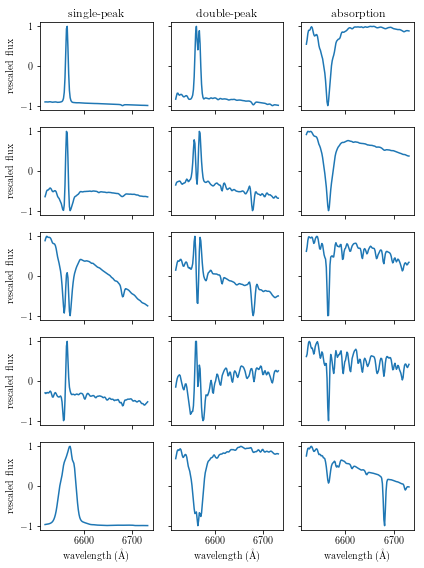

In [12]:
def preview_profiles():
    n_rows, n_cols = 5, 3
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6, 8), sharey=True, sharex=True)
    labels = ['single-peak', 'double-peak', 'absorption']
    absorption_ids = ['qf140029', 'a201403300026', 'sh240030', 'sd180014', 'a201404020024']
    emission_ids = ['lb160035', 're270010', 'sa080023', 'rh230043', 'rd270028']
    double_peak_ids = ['si220021', 'a201503170057', 'a201306110029', 'qc160050', 'oa110013']
    for i, (label, spectra_ids) in enumerate(zip(labels, (emission_ids, double_peak_ids, absorption_ids))):
        axs[0][i].set_title(label)
        for j, spectrum_id in enumerate(spectra_ids):
            plot.plot_ondrejov_spectrum(spectrum_id, (ids_train, X_train, labels_train, y_train), axs[j][i])
    for ax in axs[-1]:
        ax.set_xlabel('wavelength (\AA)')
    for idx in range(n_rows):
        axs[idx][0].set_ylabel('rescaled flux')
    fig.tight_layout()
    plt.savefig('figures/profiles.pdf')
    plt.show()
    plt.close()

preview_profiles()

## Method

In [10]:
# create data structure
data_dict = learning.initialize(ids_train, X_train, y_train, ids, X)

In [11]:
print('in iteration:', data_dict['it'])

in iteration: 0


In [12]:
data_dict = learning.learning(data_dict)

Epoch 1/1000
18306/18306 [==============================] - 19s 1ms/step - loss: 0.2072
Epoch 2/1000
18306/18306 [==============================] - 4s 197us/step - loss: 0.0841
Epoch 3/1000
18306/18306 [==============================] - 4s 197us/step - loss: 0.0712
Epoch 4/1000
18306/18306 [==============================] - 4s 199us/step - loss: 0.0646
Epoch 5/1000
18306/18306 [==============================] - 3s 190us/step - loss: 0.0605
Epoch 6/1000
18306/18306 [==============================] - 4s 200us/step - loss: 0.0596
Epoch 7/1000
18306/18306 [==============================] - 4s 198us/step - loss: 0.0551
Epoch 8/1000
18306/18306 [==============================] - 4s 200us/step - loss: 0.0502
Epoch 9/1000
18306/18306 [==============================] - 3s 186us/step - loss: 0.0503
Epoch 10/1000
18306/18306 [==============================] - 4s 199us/step - loss: 0.0500
Epoch 11/1000
18306/18306 [==============================] - 4s 203us/step - loss: 0.0467
Epoch 12/1000
18306/

In [13]:
# show number of predictions in each class
learning.show_prediction_stats(data_dict)

(array([0, 1, 2]), array([3851361,  114401,  170720]))

In [14]:
# performance estimation
random_spectra = learning.get_random_spectra(data_dict)

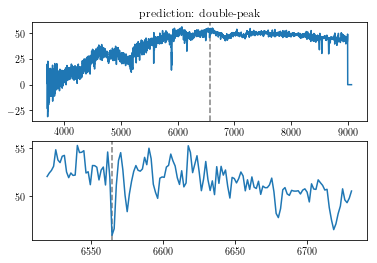

In [15]:
identifier, prediction = next(random_spectra)
plot.preview_lamost_spectrum(identifier, prediction)

In [ ]:
learning.mark_emission(identifier, data_dict, prediction)

In [ ]:
learning.mark_not_interesting(identifier, data_dict, prediction)

In [ ]:
learning.mark_double_peak(identifier, data_dict, prediction)

In [ ]:
plot.plot_performance(data_dict['est_perf_df'])

In [ ]:
# active learning
reclassification_spectra = learning.get_reclassification_spectra(data_dict)

In [ ]:
identifier, prediction = next(reclassification_spectra)
plot.preview_lamost_spectrum(identifier, prediction)

In [ ]:
learning.classify_not_interesting(identifier, data_dict, prediction)

In [ ]:
learning.classify_emission(identifier, data_dict, prediction)

In [ ]:
learning.classify_double_peak(identifier, data_dict, prediction)

In [ ]:
# increment iteration and renew datasets
data_dict = learning.next_iteration(data_dict)

In [ ]:
# at the end store candidates with labels in a CSV file
learning.save_candidates(data_dict)

In [ ]:
learning.finalize(data_dict)